1. テーマ
ソウルのPM10とPM2.5を予測するマシンラーニング

2. 企画、目標
ソウルはPM10とPM2.5で悩まされ、外出するすると必ずマスクをつけるようになりました。韓国の国内で発生したものだとしたら、四季によることは少ないことが当然ですが、冬と春はひどく濃いPM2.5で、中国を疑っています。

それで、私たちは北京とソウルの空気のデータを使い、ソウルの一年間のPM10とPM2.5の予報が出来るようにするとともにどのくらい中国からの影響があるのか試してみようとしております。


# Package Import 

In [3]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Data Preprocessing

## (Seoul) String Date To Unix Time Stamp

In [4]:
from datetime import datetime
import time

def make_date_list(np_list, col):
  return_list = []
  epoch_time = datetime(1970, 1, 1)
  date_format = '%Y-%m-%d:%H'
  

  for row in np_list[col]:
    tmp = row.split(':')
    added_time = 0

    if tmp[1] == '24':
      row = tmp[0]+":00"
      added_time = 86400
    

    return_list.append(
        (datetime.strptime(row, date_format) - epoch_time).total_seconds() + added_time
    )
  
  return return_list


seoul_2015_df = pd.read_excel('2015_Air_Quality_Seoul.xls')
seoul_2016_df = pd.read_excel('2016_Air_Quality_Seoul.xls')
date_2015_list = make_date_list(seoul_2015_df, '날짜')
date_2016_list = make_date_list(seoul_2016_df, '날짜')

sr1 = pd.Series(date_2015_list, name='unix_time')
sr2 = pd.Series(date_2016_list, name='unix_time')

seoul_2015_df = seoul_2015_df.drop('날짜', axis=1)
seoul_2016_df = seoul_2016_df.drop('날짜', axis=1)

seoul_2015_df = pd.concat([sr1, seoul_2015_df], axis=1)
seoul_2016_df = pd.concat([sr1, seoul_2016_df], axis=1)
seoul_15_16_df = pd.concat([seoul_2015_df, seoul_2015_df], axis=0)

seoul_15_16_df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Ozone,NO2,NO,SO2,Wind speed,Wind direction
0,1.420074e+09,44.0,0.022,0.022,0.011,0.6,0.006,4.7,WNW
1,1.420078e+09,57.0,0.022,0.022,0.010,0.6,0.006,4.5,WNW
2,1.420081e+09,76.0,0.021,0.021,0.010,0.6,0.006,3.8,WNW
3,1.420085e+09,86.0,0.022,0.022,0.009,0.6,0.006,4.9,WNW
4,1.420088e+09,106.0,0.021,0.021,0.009,0.5,0.006,5.7,WNW
...,...,...,...,...,...,...,...,...,...
8755,1.451592e+09,88.0,0.003,0.003,0.075,1.0,0.009,0.8,NE
8756,1.451596e+09,84.0,0.003,0.003,0.080,1.2,0.009,1.2,NE
8757,1.451599e+09,97.0,0.003,0.003,0.076,1.1,0.008,1.1,NE
8758,1.451603e+09,93.0,0.002,0.002,0.078,1.1,0.008,0.8,NE


## (Seoul) Drop some of useless columns

In [5]:
seoul_15_16_df = seoul_15_16_df.drop(['Ozone', 'NO2', 'NO', 'SO2',], axis=1)
seoul_15_16_df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Wind speed,Wind direction
0,1.420074e+09,44.0,0.022,4.7,WNW
1,1.420078e+09,57.0,0.022,4.5,WNW
2,1.420081e+09,76.0,0.021,3.8,WNW
3,1.420085e+09,86.0,0.022,4.9,WNW
4,1.420088e+09,106.0,0.021,5.7,WNW
...,...,...,...,...,...
8755,1.451592e+09,88.0,0.003,0.8,NE
8756,1.451596e+09,84.0,0.003,1.2,NE
8757,1.451599e+09,97.0,0.003,1.1,NE
8758,1.451603e+09,93.0,0.002,0.8,NE


## (Seoul) Categorize wind direction

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
wd_seoul = encoder.fit_transform(seoul_15_16_df['Wind direction'])
wd_seoul = pd.Series(wd_seoul.tolist(), name='Wind direction')
seoul_15_16_df = seoul_15_16_df.reset_index()

seoul_15_16_df = seoul_15_16_df.drop('Wind direction', axis=1)
seoul_15_16_df = pd.concat([seoul_15_16_df, wd_seoul], axis=1)
seoul_15_16_df

,index,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Wind speed,Wind direction
0,0,1.420074e+09,44.0,0.022,4.7,14
1,1,1.420078e+09,57.0,0.022,4.5,14
2,2,1.420081e+09,76.0,0.021,3.8,14
3,3,1.420085e+09,86.0,0.022,4.9,14
4,4,1.420088e+09,106.0,0.021,5.7,14
...,...,...,...,...,...,...
17515,8755,1.451592e+09,88.0,0.003,0.8,4
17516,8756,1.451596e+09,84.0,0.003,1.2,4
17517,8757,1.451599e+09,97.0,0.003,1.1,4
17518,8758,1.451603e+09,93.0,0.002,0.8,4


## (Seoul) Remove Null Values

In [7]:
seoul_15_16_df = seoul_15_16_df.dropna()
seoul_15_16_df = seoul_15_16_df.drop('index', axis=1)
seoul_15_16_df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Wind speed,Wind direction
0,1.420074e+09,44.0,0.022,4.7,14
1,1.420078e+09,57.0,0.022,4.5,14
2,1.420081e+09,76.0,0.021,3.8,14
3,1.420085e+09,86.0,0.022,4.9,14
4,1.420088e+09,106.0,0.021,5.7,14
...,...,...,...,...,...
17515,1.451592e+09,88.0,0.003,0.8,4
17516,1.451596e+09,84.0,0.003,1.2,4
17517,1.451599e+09,97.0,0.003,1.1,4
17518,1.451603e+09,93.0,0.002,0.8,4


In [8]:
seoul_15_16_df.isnull().sum()

unix_time         0
PM10(㎍/㎥)         0
PM2.5(㎍/㎥)        0
Wind speed        0
Wind direction    0
dtype: int64

In [9]:
seoul_15_16_df.isnull().sum()

unix_time         0
PM10(㎍/㎥)         0
PM2.5(㎍/㎥)        0
Wind speed        0
Wind direction    0
dtype: int64

## (Beijing) String Date to Unix Stamp 

In [10]:
china_df = pd.read_csv('2015-2017 PRSA_Data_Aotizhongxin.csv')
china_strdate_df = china_df.loc[:, 'year':'hour'].astype('str')
china_sr = china_strdate_df['year'] + '-' + china_strdate_df['month'] + '-' + china_strdate_df['day'] + ':' + china_strdate_df['hour']
china_sr = china_sr.rename('날짜')

china_df = china_df.drop(['No', 'year', 'month', 'day', 'hour'], axis=1)
china_df = pd.concat([china_sr, china_df], axis=1)

china_time_stamp_list = date_2015_list = make_date_list(china_df, '날짜')
china_sr = pd.Series(china_time_stamp_list, name='unix_time')
china_df = china_df.drop('날짜', axis=1)
china_df = pd.concat([china_sr, china_df], axis=1)
china_df

,unix_time,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1.420070e+09,13.0,50.0,19.0,29.0,500.0,28.0,-1.0,1027.0,-22.4,0.0,NNW,4.4,Aotizhongxin
1,1.420074e+09,11.0,30.0,15.0,31.0,600.0,27.0,-1.0,1027.0,-23.7,0.0,N,5.6,Aotizhongxin
2,1.420078e+09,13.0,33.0,16.0,32.0,600.0,26.0,-1.0,1028.0,-23.7,0.0,N,4.2,Aotizhongxin
3,1.420081e+09,10.0,29.0,10.0,25.0,500.0,31.0,-1.0,1029.0,-24.4,0.0,N,4.4,Aotizhongxin
4,1.420085e+09,12.0,25.0,14.0,33.0,700.0,24.0,-2.0,1027.0,-23.2,0.0,ENE,1.4,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18955,1.488308e+09,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
18956,1.488312e+09,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
18957,1.488316e+09,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
18958,1.488319e+09,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin


## (Beijing) Drop some of useless columns

In [11]:
china_df = china_df.drop(['SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'station'], axis=1)
china_df

,unix_time,PM2.5,PM10,wd,WSPM
0,1.420070e+09,13.0,50.0,NNW,4.4
1,1.420074e+09,11.0,30.0,N,5.6
2,1.420078e+09,13.0,33.0,N,4.2
3,1.420081e+09,10.0,29.0,N,4.4
4,1.420085e+09,12.0,25.0,ENE,1.4
...,...,...,...,...,...
18955,1.488308e+09,12.0,29.0,NW,2.4
18956,1.488312e+09,13.0,37.0,WNW,0.9
18957,1.488316e+09,16.0,37.0,NW,1.1
18958,1.488319e+09,21.0,44.0,NNW,1.2


## (Beijing) Remove Null Values

In [12]:
china_df.isnull().sum()

unix_time      0
PM2.5        409
PM10         226
wd            78
WSPM          14
dtype: int64

In [13]:
china_df = china_df.dropna()
china_df.reset_index()
china_df.isnull().sum()

unix_time    0
PM2.5        0
PM10         0
wd           0
WSPM         0
dtype: int64

## (Beijing) Categorize wind direction

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
wd_beijing = encoder.fit_transform(china_df['wd'])
wd_beijing = pd.Series(wd_beijing.tolist(), name='wd')
china_df = china_df.reset_index()

china_df = china_df.drop('wd', axis=1)
china_df = pd.concat([china_df, wd_beijing], axis=1)
china_df

,index,unix_time,PM2.5,PM10,WSPM,wd
0,0,1.420070e+09,13.0,50.0,4.4,6
1,1,1.420074e+09,11.0,30.0,5.6,3
2,2,1.420078e+09,13.0,33.0,4.2,3
3,3,1.420081e+09,10.0,29.0,4.4,3
4,4,1.420085e+09,12.0,25.0,1.4,1
...,...,...,...,...,...,...
18464,18955,1.488308e+09,12.0,29.0,2.4,7
18465,18956,1.488312e+09,13.0,37.0,0.9,14
18466,18957,1.488316e+09,16.0,37.0,1.1,7
18467,18958,1.488319e+09,21.0,44.0,1.2,6


## Date alignment

In [15]:
china_df_copy = china_df.copy()
china_df_copy['unix_time'] = china_df_copy['unix_time']+86400
seoul_15_16_df['unix_time'] = seoul_15_16_df['unix_time']


china_df_copy = china_df_copy.drop('index', axis=1)
china_df_copy.columns = ['unix_time', 'PM2.5_ch', 'PM10_ch', 'WSPM_ch', 'wd_ch']
china_df_copy

,unix_time,PM2.5_ch,PM10_ch,WSPM_ch,wd_ch
0,1.420157e+09,13.0,50.0,4.4,6
1,1.420160e+09,11.0,30.0,5.6,3
2,1.420164e+09,13.0,33.0,4.2,3
3,1.420168e+09,10.0,29.0,4.4,3
4,1.420171e+09,12.0,25.0,1.4,1
...,...,...,...,...,...
18464,1.488395e+09,12.0,29.0,2.4,7
18465,1.488398e+09,13.0,37.0,0.9,14
18466,1.488402e+09,16.0,37.0,1.1,7
18467,1.488406e+09,21.0,44.0,1.2,6


# Merge dataframes

In [16]:
df = pd.merge(seoul_15_16_df, china_df_copy, on='unix_time')
df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Wind speed,Wind direction,PM2.5_ch,PM10_ch,WSPM_ch,wd_ch
0,1.420157e+09,21.0,0.021,2.4,13,13.0,50.0,4.4,6
1,1.420157e+09,21.0,0.021,2.4,13,13.0,50.0,4.4,6
2,1.420160e+09,25.0,0.020,1.1,6,11.0,30.0,5.6,3
3,1.420160e+09,25.0,0.020,1.1,6,11.0,30.0,5.6,3
4,1.420164e+09,24.0,0.023,1.8,13,13.0,33.0,4.2,3
...,...,...,...,...,...,...,...,...,...
16661,1.451599e+09,97.0,0.003,1.1,4,17.0,17.0,1.3,4
16662,1.451603e+09,93.0,0.002,0.8,4,22.0,22.0,1.5,3
16663,1.451603e+09,93.0,0.002,0.8,4,22.0,22.0,1.5,3
16664,1.451606e+09,86.0,0.002,2.2,5,33.0,33.0,0.9,5


In [17]:
df.isnull().sum()

unix_time         0
PM10(㎍/㎥)         0
PM2.5(㎍/㎥)        0
Wind speed        0
Wind direction    0
PM2.5_ch          0
PM10_ch           0
WSPM_ch           0
wd_ch             0
dtype: int64

# Model

## Scailing

In [18]:
time_sr = df['unix_time'] / 10**9
time_sr = time_sr.rename('unix_time')

In [19]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
title = ['unix_time',	'PM10(㎍/㎥)', 'PM2.5(㎍/㎥)',	'Wind speed', 'Wind direction', 'PM2.5_ch', 'PM10_ch', 'WSPM_ch', 'wd_ch']
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=title)
scaled_df['unix_time'] = time_sr
scaled_df

,unix_time,PM10(㎍/㎥),PM2.5(㎍/㎥),Wind speed,Wind direction,PM2.5_ch,PM10_ch,WSPM_ch,wd_ch
0,1.420157,-0.508514,-0.088903,-0.160771,0.876834,-0.806020,-0.621355,2.030703,-0.063249
1,1.420157,-0.508514,-0.088903,-0.160771,0.876834,-0.806020,-0.621355,2.030703,-0.063249
2,1.420160,-0.421700,-0.142911,-1.060271,-0.443385,-0.829415,-0.820923,2.998519,-0.683801
3,1.420160,-0.421700,-0.142911,-1.060271,-0.443385,-0.829415,-0.820923,2.998519,-0.683801
4,1.420164,-0.443403,0.019113,-0.575925,0.876834,-0.806020,-0.790988,1.869401,-0.683801
...,...,...,...,...,...,...,...,...,...
16661,1.451599,1.140966,-1.061046,-1.060271,-0.820590,-0.759229,-0.950643,-0.469487,-0.476950
16662,1.451603,1.054151,-1.115054,-1.267848,-0.820590,-0.700741,-0.900751,-0.308184,-0.683801
16663,1.451603,1.054151,-1.115054,-1.267848,-0.820590,-0.700741,-0.900751,-0.308184,-0.683801
16664,1.451606,0.902225,-1.115054,-0.299155,-0.631988,-0.572067,-0.790988,-0.792092,-0.270100


## Data split

In [20]:
x = scaled_df.loc[:, 'PM2.5_ch':]
x['unix_time'] = scaled_df['unix_time']
y_pm10 = scaled_df['PM10(㎍/㎥)']
y_pm25 = scaled_df['PM2.5(㎍/㎥)']
y_pm10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0       -0.508514
1       -0.508514
2       -0.421700
3       -0.421700
4       -0.443403
           ...   
16661    1.140966
16662    1.054151
16663    1.054151
16664    0.902225
16665    0.902225
Name: PM10(㎍/㎥), Length: 16666, dtype: float64

In [21]:
# 데이터 분할하기
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y_pm10, test_size=0.30, random_state=5)
print('x_train: ', x_train.shape)
print('x_test:', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (11666, 5)
x_test: (5000, 5)
y_train:  (11666,)
y_test:  (5000,)


## Model Learning1

In [22]:
BATCH_SIZE = 32
EPOCH_SIZE = 128

In [23]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=5)) # 12개가 들어와 200개로 나뉜다
model.add(Dense(units=200, activation='relu')) # 200개가 들어와
model.add(Dense(units=100, activation='relu')) # 100개가 들어와
model.add(Dense(units=50, activation='relu')) # 50개가 들어와
model.add(Dense(units=50, activation='relu')) # 50개가 들어와
model.add(Dense(units=1, activation='linear')) # 마지막 출구로 1개에 리니어

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 69,151
Trainable params: 69,151
Non-trainable params: 0
____________________________________________________

In [24]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(x_train, y_train, verbose=1, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Epoch 1/128
365/365 [==============================] - 5s 4ms/step - loss: 0.7353 - accuracy: 0.0000e+00 - val_loss: 0.8975 - val_accuracy: 0.0000e+00
Epoch 2/128
365/365 [==============================] - 1s 3ms/step - loss: 0.5602 - accuracy: 0.0000e+00 - val_loss: 0.6972 - val_accuracy: 0.0000e+00
Epoch 3/128
365/365 [==============================] - 1s 3ms/step - loss: 0.6440 - accuracy: 0.0000e+00 - val_loss: 0.7669 - val_accuracy: 0.0000e+00
Epoch 4/128
365/365 [==============================] - 1s 3ms/step - loss: 0.7219 - accuracy: 0.0000e+00 - val_loss: 0.7223 - val_accuracy: 0.0000e+00
Epoch 5/128
365/365 [==============================] - 1s 3ms/step - loss: 0.6302 - accuracy: 0.0000e+00 - val_loss: 0.6596 - val_accuracy: 0.0000e+00
Epoch 6/128
365/365 [==============================] - 1s 3ms/step - loss: 0.6393 - accuracy: 0.0000e+00 - val_loss: 0.7106 - val_accuracy: 0.0000e+00
Epoch 7/128
365/365 [==============================] - 1s 3ms/step - loss: 0.5765 - accuracy: 

# Predict

In [30]:
# 예측, y값을 주면 안된다.
pred = model.predict(x_test)
print(pred.shape, y_test.shape, x_test['unix_time'].shape)
pred

(5000, 1) (5000,) (5000,)


array([[-0.11373074],
       [-0.17027204],
       [-0.02108197],
       ...,
       [ 0.30195203],
       [ 0.1856117 ],
       [-0.04424618]], dtype=float32)

## Scatter plot (Corrects vs Predictions)

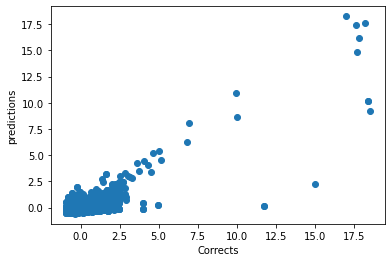

In [26]:
plt.scatter(y_test, pred)
plt.xlabel('Corrects')
plt.ylabel('predictions')
plt.show()

## Time evolution plots

In [31]:
time_tst_sr = x_test['unix_time']
pred = pd.Series(pred.reshape(5000,), name='predictions')
df_label = pd.concat([time_tst_sr, y_test], axis=1)
time_tsr_sr2 = time_tst_sr.reset_index()
df_pred = pd.concat([time_tsr_sr2, pred], axis=1)
df_label = df_label.sort_values(by=['unix_time'])
df_pred = df_pred.sort_values(by=['unix_time'])
df_pred

,index,unix_time,predictions
3825,6,1.420168,0.254827
1568,9,1.420171,-0.197356
645,8,1.420171,-0.197356
2913,11,1.420175,-0.239200
1725,15,1.420182,-0.204309
...,...,...,...
2153,16642,1.451567,-0.214286
117,16644,1.451570,-0.215308
2409,16656,1.451592,-0.295977
2920,16659,1.451596,-0.269282


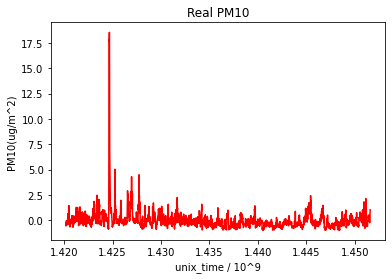

In [32]:
plt.plot(df_label['unix_time'], df_label['PM10(㎍/㎥)'], color='red')
plt.xlabel('unix_time / 10^9')
plt.ylabel('PM10(ug/m^2)')
plt.title('Real PM10')
plt.show()

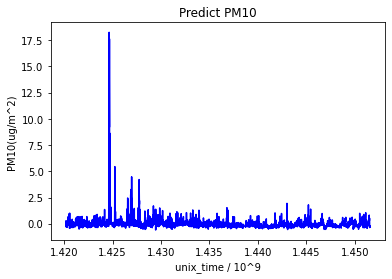

In [33]:
plt.plot(df_pred['unix_time'], df_pred['predictions'], color='blue')
plt.xlabel('unix_time / 10^9')
plt.ylabel('PM10(ug/m^2)')
plt.title('Predict PM10')
plt.show()